# Importing libraries

In [59]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

import re
import tqdm
import operator
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras import backend as K

### Scikit-learn dependencies ###
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

### nltk dependencies ###
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

### Download nltk data ###
!python3 -m nltk.downloader punkt
!python3 -m nltk.downloader stopwords
!python3 -m nltk.downloader wordnet

### Some constants ###
# true_path = "/content/drive/My Drive/True.csv"
# fake_path = "/content/drive/My Drive/Fake.csv"
true_path = "../data/True.csv"
fake_path = "../data/Fake.csv"

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /home/minhhieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/minhhieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading pack

# Loading and preprocessing text data

### Loading data

In [17]:
df_true = pd.read_csv(true_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))
df_fake = pd.read_csv(fake_path, header=0).sample(n=10000, random_state=np.random.randint(0,40000))

df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake])

df.head(10)

,title,text,subject,date,label
12690,U.S. presses Russia to comply with nuclear mis...,WASHINGTON (Reuters) - The United States is re...,worldnews,"December 8, 2017",1
15667,Saudi Arabia says it intercepts missile close ...,RIYADH (Reuters) - Saudi Arabia s air defense ...,worldnews,"November 4, 2017",1
12379,Nigeria NGOs slam civil society bill as grave ...,ABUJA (Reuters) - A bill proposed by Nigerian ...,worldnews,"December 13, 2017",1
1271,Mexico says NAFTA would survive with Canada ev...,MEXICO CITY (Reuters) - Mexico would keep trad...,politicsNews,"October 13, 2017",1
8181,Clinton scheduled to return to campaign trail ...,WASHINGTON (Reuters) - Democratic presidential...,politicsNews,"September 13, 2016",1
8703,Melania Trump's RNC speech produces so-so TV a...,(Reuters) - Melania Trump’s big night at the R...,politicsNews,"July 19, 2016",1
2092,Unwavering Trump voters say they will not miss...,CHICAGO (Reuters) - Former White House chief s...,politicsNews,"August 19, 2017",1
13291,UAE says Egyptian ex-premier Shafik left for E...,DUBAI (Reuters) - Former Egyptian prime minist...,worldnews,"December 2, 2017",1
8269,Trump raises possibility of eventual legal sta...,"YOUNGSTOWN, Ohio (Reuters) - In a new twist to...",politicsNews,"September 5, 2016",1
4305,Mattis says U.S. military policy in Syria unch...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,politicsNews,"April 11, 2017",1


### Cleaning text data

In [18]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

stop_words = set(stopwords.words('english')) # Assuming all nltk data is installed
lemmatizer = WordNetLemmatizer()

def filter_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    filtered_sentence = ' '.join(filtered)

    ### Removing all special characters ###
    special_chars = ['…', '–', '’', '‘', '”', '“']

    for char_ in special_chars:
        filtered_sentence = filtered_sentence.replace(char_, "")

    # Removal of extra spaces
    filtered_sentence = re.sub(' +',' ',filtered_sentence)
    return filtered_sentence

def preprocessing_text(text):
    ### 1. Removing tags and accented data ###
    text = cleanhtml(text)
    text = remove_accents(text)

    ### 2. Expanding contractions ###
    text = expand_contractions(text)

    ### 3. Removing punctuations + lowercasing ###
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    ### 4. Removing special characters ### 
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove non-text chars
    text = re.sub(' +',' ',text) # Remove extra spaces
    text = re.sub('\w*\d\w*','', text) # Remove digits

    ### 5. Lemmatization and stopwords removal ###
    text = filter_stopwords(text)

    return text

In [19]:
df['title'] = df['title'].apply(lambda x : preprocessing_text(x))
df['text']  = df['text'].apply(lambda x : preprocessing_text(x))
df['title'].head(10)

12690         u press russia comply nuclear missile treaty
15667     saudi arabia say intercept missile close capital
12379    nigeria ngo slam civil society bill grave thre...
1271     mexico say nafta would survive canada even wit...
8181     clinton scheduled return campaign trail friday...
8703     melania trump rnc speech produce soso tv audience
2092          unwavering trump voter say miss steve bannon
13291    uae say egyptian expremier shafik left egypt f...
8269     trump raise possibility eventual legal status ...
4305          mattis say u military policy syria unchanged
Name: title, dtype: object

### Word-Frequency map

[INFO] Calculating word-frequency map ...


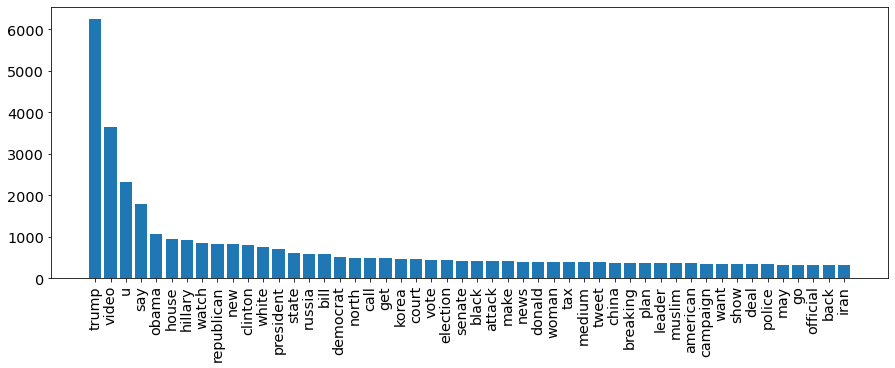

In [62]:
word_freq = {}
all_words = ' '.join(df['title'].values).split(' ')

print('[INFO] Calculating word-frequency map ...')
for w in all_words:
    if(w not in word_freq):
        word_freq[w] = 0
    else:
        word_freq[w] += 1
        
word_freq = dict( sorted(word_freq.items(), key=operator.itemgetter(1),reverse=True))
top_50_keys = list(word_freq.keys())[0:50]
top_50_words = dict([(key, word_freq[key]) for key in top_50_keys])

words = list(top_50_words.keys())
freqs = list(top_50_words.values())

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(words, freqs)

pylab.rcParams.update(params)
plt.xticks(rotation=90)
plt.show()

# Feature engineering methods comparision

In [21]:
count_vec = CountVectorizer(min_df=5)
bi_count_vec = CountVectorizer(min_df=3, ngram_range=(1,2))
tf_idf_vec = TfidfVectorizer(min_df=5)

features_text = df['title'].values
targets = df['label'].values

### Using Bag-of-words ###
model = LogisticRegression()
features = count_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_bow = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using BOW : {accuracy_bow}')

### Using N-gram Bow ###
model = LogisticRegression()
features = bi_count_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_ngram = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using Ngram-BOW : {accuracy_ngram}')

### Using Tf-Idf ###
model = LogisticRegression()
features = tf_idf_vec.fit_transform(features_text).toarray()
x_train, x_val, y_train, y_val = train_test_split(features, targets, test_size=0.33333)
model.fit(x_train, y_train)
predictions = model.predict(x_val)
accuracy_tf_idf = accuracy_score(y_val, predictions)
print(f'[INFO] Accuracy of logistic regression when using BOW : {accuracy_tf_idf}')

[INFO] Accuracy of logistic regression when using BOW : 0.9350532473376331
[INFO] Accuracy of logistic regression when using Ngram-BOW : 0.9382030898455077
[INFO] Accuracy of logistic regression when using BOW : 0.9323533823308835


# Feature engineerning with GloVe

### Loading embeddings